# CNN with reduced features from dataset and generated features

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../datasets/combined_reduced.csv')

In [3]:
X1 = np.load('../datasets/final_X.npy')

In [4]:
# Convert the DataFrame to a NumPy array
df_array = df.to_numpy()

# Stack the DataFrame and the NumPy array horizontally
X_final = np.hstack((df_array, X1))

In [5]:
target = pd.read_csv('../datasets/kag_red.csv')

In [6]:
from sklearn.model_selection import train_test_split

y = target['subreddit']  # Target

In [7]:
# merge X_final and y to single dataframe
df_final = pd.DataFrame(X_final)
df_final['subreddit'] = y

In [8]:
import pandas as pd
import numpy as np


# Get indexes of rows where subreddit is 'depression'
depression_rows = df_final[df_final['subreddit'] == 'depression'].index

# Calculate the number of rows to keep and remove for 'depression' subreddit
total_depression_rows = len(depression_rows)
rows_to_keep = int(total_depression_rows * 0.57)  


rows_to_keep_indexes = np.random.choice(depression_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = depression_rows.difference(rows_to_keep_indexes)

df_final.drop(rows_to_remove_indexes, inplace=True)




In [9]:

s_rows = df_final[df_final['subreddit'] == 'suicidewatch'].index


total_s_rows = len(s_rows)
rows_to_keep = int(total_s_rows * 0.90)  


rows_to_keep_indexes = np.random.choice(s_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = s_rows.difference(rows_to_keep_indexes)


df_final.drop(rows_to_remove_indexes, inplace=True)

In [10]:

X_final_d = df_final.drop('subreddit', axis=1)
y_final_d = df_final['subreddit']


In [11]:
# convert X_final_d and y_final_d to numpy arrays
X_final_d = X_final_d.to_numpy()

In [12]:
# print the shape of X_final and y
print(X_final_d.shape)
print(y_final_d.shape)

(317429, 1140)
(317429,)


In [13]:
# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_d, y_final_d, test_size=0.2, random_state=42)


In [14]:

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 

# Step 1: Encode the categorical target variable (y_train) using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))
# Step 2: Flatten the encoded labels
y_train_encoded = y_train_encoded.argmax(axis=1)
y_val_encoded = y_val_encoded.argmax(axis=1)
y_test_encoded = y_test_encoded.argmax(axis=1)
y_train_encoded = to_categorical(y_train_encoded) 
y_val_encoded = to_categorical(y_val_encoded) 
y_test_encoded_cat = to_categorical(y_test_encoded)

In [16]:

print(y_test_encoded_cat.shape)

(63486, 11)


## Compiling and training the model

In [17]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'CNN_reduced_full.ipynb'

In [18]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import accuracy_score
import numpy as np

wandb.init(project='Best_models', name='CNN_b_reduced')

params = {
    'filters': 16, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 200, 'act': 'tanh'
}

wandb: Currently logged in as: aayushach16 (boys69). Use `wandb login --relogin` to force relogin


In [19]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 3 or epoch == 6:  
            self.model.save("model_relu_{}.hd5".format(epoch))

In [20]:
import tensorflow as tf

model = Sequential()
model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation=params['act'],
                 input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=params['pool_size']))
model.add(Flatten())
model.add(Dense(params['dense_units'], activation=params['act']))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

saver = CustomSaver()

history = model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=16,
                    validation_data=(X_val_reshaped, y_val_encoded),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                               WandbCallback(), saver])

X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
11893/11904 [============================>.] - ETA: 0s - loss: 1.0333 - accuracy: 0.6514

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


11904/11904 [==============================] - 55s 5ms/step - loss: 1.0332 - accuracy: 0.6515 - val_loss: 0.8928 - val_accuracy: 0.6956
Epoch 2/10
11896/11904 [============================>.] - ETA: 0s - loss: 0.8452 - accuracy: 0.7088

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


11904/11904 [==============================] - 53s 4ms/step - loss: 0.8452 - accuracy: 0.7087 - val_loss: 0.8489 - val_accuracy: 0.7041
Epoch 3/10
11902/11904 [============================>.] - ETA: 0s - loss: 0.8164 - accuracy: 0.7171

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


11904/11904 [==============================] - 54s 5ms/step - loss: 0.8164 - accuracy: 0.7170 - val_loss: 0.8401 - val_accuracy: 0.7097
Epoch 4/10
11897/11904 [============================>.] - ETA: 0s - loss: 0.7986 - accuracy: 0.7232

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: model_relu_3.hd5/assets


INFO:tensorflow:Assets written to: model_relu_3.hd5/assets


11904/11904 [==============================] - 57s 5ms/step - loss: 0.7985 - accuracy: 0.7232 - val_loss: 0.8209 - val_accuracy: 0.7148
Epoch 5/10
11900/11904 [============================>.] - ETA: 0s - loss: 0.7851 - accuracy: 0.7260

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


11904/11904 [==============================] - 61s 5ms/step - loss: 0.7851 - accuracy: 0.7260 - val_loss: 0.8171 - val_accuracy: 0.7175
Epoch 6/10
11902/11904 [============================>.] - ETA: 0s - loss: 0.7732 - accuracy: 0.7291

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


11904/11904 [==============================] - 60s 5ms/step - loss: 0.7731 - accuracy: 0.7291 - val_loss: 0.8100 - val_accuracy: 0.7154
Epoch 7/10
11898/11904 [============================>.] - ETA: 0s - loss: 0.7629 - accuracy: 0.7325

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: model_relu_6.hd5/assets


INFO:tensorflow:Assets written to: model_relu_6.hd5/assets


11904/11904 [==============================] - 61s 5ms/step - loss: 0.7629 - accuracy: 0.7325 - val_loss: 0.8018 - val_accuracy: 0.7171
Epoch 8/10
11894/11904 [============================>.] - ETA: 0s - loss: 0.7538 - accuracy: 0.7341

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


11904/11904 [==============================] - 59s 5ms/step - loss: 0.7538 - accuracy: 0.7342 - val_loss: 0.8009 - val_accuracy: 0.7207
Epoch 9/10
11902/11904 [============================>.] - ETA: 0s - loss: 0.7448 - accuracy: 0.7364

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


11904/11904 [==============================] - 70s 6ms/step - loss: 0.7449 - accuracy: 0.7364 - val_loss: 0.7934 - val_accuracy: 0.7224
Epoch 10/10
11904/11904 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.7398

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/best_models/wandb/run-20231130_181315-fep0121m/files/model-best)... Done. 0.1s


1984/1984 [==============================] - 3s 1ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Save X_test_reshaped and y_test_encoded_cat to numpy arrays

np.save('../inferencing/data/X_test_CNN_reduced_full.npy', X_test_reshaped)
np.save('../inferencing/data/y_test_encoded_CNN_reduced_full.npy', y_test_encoded)

In [21]:

accuracy = accuracy_score(y_test_encoded, y_pred_classes)


In [22]:

accr = model.evaluate(X_test_reshaped, y_test_encoded_cat)

wandb.log({'test_loss': accr[0], 'test_acc': accr[1]})
wandb.log({'validation_loss': history.history['val_loss'][len(history.history['val_loss']) - 1], 'epoch': len(history.history['val_loss'])})





1984/1984 [==============================] - 3s 1ms/step - loss: 0.7890 - accuracy: 0.7234


## Results

In [23]:

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes))

Accuracy: 0.7233720820338342
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1529
           1       0.85      0.88      0.87      9244
           2       0.69      0.82      0.75      1178
           3       0.80      0.81      0.81     11401
           4       0.82      0.73      0.77      1791
           5       0.83      0.59      0.69      4900
           6       0.62      0.55      0.59     13427
           7       0.68      0.68      0.68      4752
           8       0.77      0.68      0.72      1713
           9       0.74      0.62      0.68      1772
          10       0.62      0.80      0.70     11779

    accuracy                           0.72     63486
   macro avg       0.75      0.71      0.73     63486
weighted avg       0.73      0.72      0.72     63486



In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute confusion matrix in percentage of total test samples
cm = confusion_matrix(y_test_encoded, y_pred_classes)


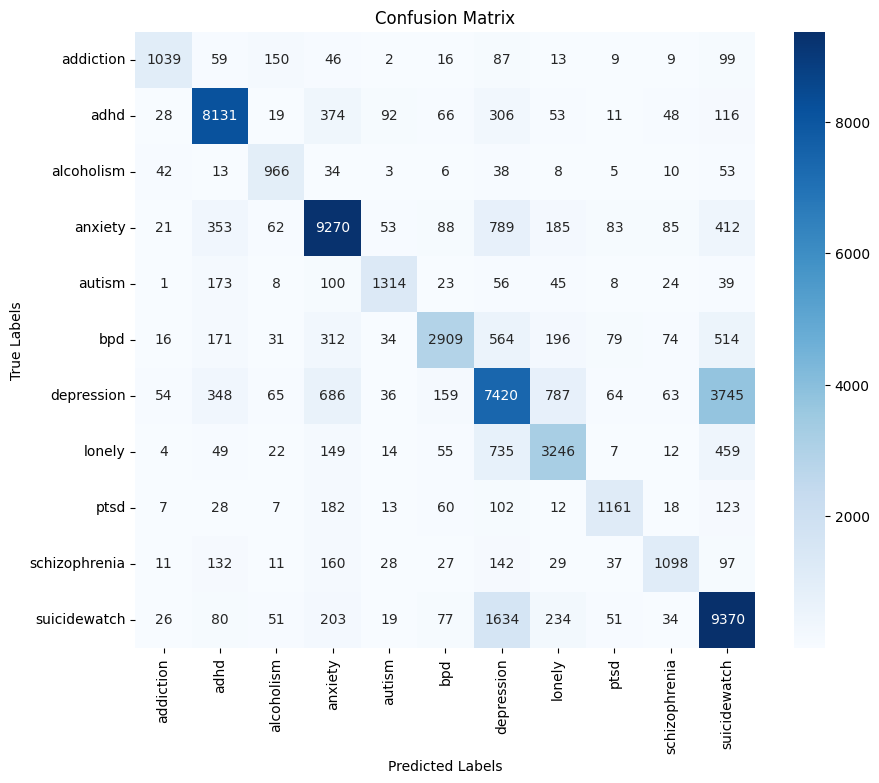

In [25]:


# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [26]:
# print count of categories in y_test
print(y_test.value_counts())

subreddit
depression       13427
suicidewatch     11779
anxiety          11401
adhd              9244
bpd               4900
lonely            4752
autism            1791
schizophrenia     1772
ptsd              1713
addiction         1529
alcoholism        1178
Name: count, dtype: int64


In [28]:
wandb.finish()

accuracy,▁▆▆▇▇▇▇███
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▄▃▂▂▂▂▁▁▁
test_acc,▁
test_loss,▁
val_accuracy,▁▃▅▆▇▆▆▇██
val_loss,█▅▄▃▃▂▂▂▁▁
validation_loss,▁
accuracy,0.73983
best_epoch,9
best_val_loss,0.79152


In [27]:
del model